<a href="https://colab.research.google.com/github/koalalovepabro/Stock-Portfolio-Optimization/blob/main/Test/Stock_Portfolio(up_down_zero)_ver2.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **📈 종목선택 방법**
1년간 종가 데이터를 분석하여 전날 대비 종가가 오른 빈도가 높은 종목을 상위 30개 선택  



# **📊 포트폴리오 최적화 방법**  
1. **✔ Max Sharpe Ratio** : 샤프비율이 최대가 되도록 포트폴리오 최적화  
    => 수익률과 변동성을 모두 고려
2. **Efficient Risk**   : 주어진 변동성 ( target_volatility ) 보다 낮은 범위 내에서 수익률 (Return)이 최대가 되도록 포트폴리오 최적화  
    => 높은 이익을 추구하기 보다는, 비교적 위험이 낮은 투자를 원하는 투자자에게 추천
3. **Efficient Return** : 주어진 리스크 ( target_return )을 만족시키는 선에서 변동성(volatility)를 최소가 되도록 포트폴리오 최적화  
    => 높은 위험을 감수하더라도, 높은 이익을 추구하는 투자 성향을 가진 투자자에게 추천

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
!pip install -q install finance-datareader

In [ ]:
!pip install pykrx

     |████████████████████████████████| 81 kB 3.8 MB/s 
     |████████████████████████████████| 60 kB 5.8 MB/s 
     |████████████████████████████████| 251 kB 18.8 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
from pykrx import stock
import datetime
# from datetime import datetime, timedelta

In [ ]:
# 오늘 KOSPI&KOSDAQ 종목 전체 불러오기
today = datetime.datetime.today().strftime("%Y%m%d")
kospi = stock.get_market_fundamental_by_ticker(today, market='KOSPI').index
kosdaq = stock.get_market_fundamental_by_ticker(today, market='KOSDAQ').index
stocks = kospi.append(kosdaq)
stocks

Index(['095570', '006840', '027410', '282330', '138930', '001460', '001465',
       '001040', '079160', '00104K',
       ...
       '065510', '243070', '084110', '263920', '145020', '024060', '010240',
       '189980', '037440', '238490'],
      dtype='object', name='티커', length=2392)

In [ ]:
kospi

Index(['095570', '006840', '027410', '282330', '138930', '001460', '001465',
       '001040', '079160', '00104K',
       ...
       '093370', '081660', '005870', '079980', '005010', '069260', '000540',
       '000547', '000545', '003280'],
      dtype='object', name='티커', length=906)

In [ ]:
kosdaq

Index(['060310', '054620', '265520', '211270', '013720', '035760', '051500',
       '058820', '023460', '056730',
       ...
       '065510', '243070', '084110', '263920', '145020', '024060', '010240',
       '189980', '037440', '238490'],
      dtype='object', name='티커', length=1486)

In [ ]:
len(stocks)

2392

- 오늘 날짜를 기준으로, KOSPI 종목은 906개, KOSDAQ 종목은 1,486개 인것을 확인할 수 있다.
- KOSPI와 KOSDAQ 종목을 합쳐서 변수 stocks에 저장 (종목 총 2,392개)

## 종목이름과 종목코드

In [ ]:
###########추가#############
kospi_temp = fdr.StockListing('KOSPI')[['Symbol', 'Name']]
kosdaq_temp = fdr.StockListing('KOSDAQ')[['Symbol', 'Name']]
code_name_dict = pd.concat([kospi_temp,kosdaq_temp])
code_name_dict = code_name_dict.set_index('Symbol').to_dict().get('Name')
code_name_dict

{'095570': 'AJ네트웍스',
 '006840': 'AK홀딩스',
 '152100': 'ARIRANG 200',
 '295820': 'ARIRANG 200동일가중',
 '253150': 'ARIRANG 200선물레버리지',
 '253160': 'ARIRANG 200선물인버스2X',
 '395750': 'ARIRANG ESG가치주액티브',
 '395760': 'ARIRANG ESG성장주액티브',
 '278420': 'ARIRANG ESG우수기업',
 '292750': 'ARIRANG KRX300',
 '309210': 'ARIRANG KRX300헬스케어',
 '333940': 'ARIRANG KS로우볼가중TR',
 '333950': 'ARIRANG KS로우사이즈가중TR',
 '333960': 'ARIRANG KS모멘텀가중TR',
 '333970': 'ARIRANG KS밸류가중TR',
 '333980': 'ARIRANG KS퀄리티가중TR',
 '269530': 'ARIRANG S&P글로벌인프라',
 '251590': 'ARIRANG 고배당저변동50',
 '161510': 'ARIRANG 고배당주',
 '251600': 'ARIRANG 고배당주채권혼합',
 '289670': 'ARIRANG 국채선물10년',
 '298340': 'ARIRANG 국채선물3년',
 '189400': 'ARIRANG 글로벌MSCI(합성 H)',
 '278620': 'ARIRANG 단기채권액티브',
 '269540': 'ARIRANG 미국S&P500(H)',
 '287180': 'ARIRANG 미국나스닥기술주',
 '213630': 'ARIRANG 미국다우존스고배당주(합성 H)',
 '332610': 'ARIRANG 미국단기우량회사채',
 '332620': 'ARIRANG 미국장기우량회사채',
 '195970': 'ARIRANG 선진국MSCI(합성 H)',
 '238670': 'ARIRANG 스마트베타Quality채권혼합',
 '195980': 'ARIRANG 신흥국MSCI(합성 H

### 2020년

In [ ]:
def up_down_zero(code): # 종목과 연도에 맞는 상승/하락/변동 없는 날 수를 리스트 반환
    today = datetime.datetime.today().strftime("%Y-%m-%d")
    year = today[0:4]
    month_day = today[4:]
    one_year_ago = str(int(year)-1) + month_day
    
    data = fdr.DataReader( code, one_year_ago)[['Close']]
    data_rtn = data.pct_change()
    
    up = 0
    nothing = 0 
    down = 0
    for i, date in enumerate(data.index): 
        if data_rtn.Close.iloc[i] > 0:
            up = up + 1
        elif data_rtn.Close.iloc[i] == 0:
            nothing = nothing + 1
        else:
            down = down + 1
            
    total_days = len(data_rtn.index)
    return up/total_days, down/total_days, nothing/total_days

In [ ]:
df.to_csv("test.csv")def get_up_down_zero_df(stocks): # stocks 리스트를 넣으면, 상승/하락/변동없는 확률 데이터프레임 반환
    up_list = []
    down_list = []
    zero_list = []
    for i in stocks:
        temp = up_down_zero(i)
        up_list.append(temp[0])
        down_list.append(temp[1])
        zero_list.append(temp[2])
#         up_list.append(up_down_zero(i)[0])
#         down_list.append(up_down_zero(i)[1])
#         zero_list.append(up_down_zero(i)[2])
    # 데이터 프레임 만들기
    up_down_zero_df = pd.DataFrame()
    up_down_zero_df['종목 코드'] = stocks # 종목코드
    up_down_zero_df['상승 확률'] = up_list # 일간 변동률이 양수인 날의 수
    up_down_zero_df['하락 확률'] = down_list # 일간 변동률이 음수인 날의 수
    up_down_zero_df['변동 없는 확률'] = zero_list # 일간 변동률이 0인 날의 수
    
    up_down_zero_df['상승 확률 높은 순위'] = up_down_zero_df['상승 확률'].rank(ascending=False)
    up_down_zero_df = up_down_zero_df.sort_values(by='상승 확률 높은 순위')
    return up_down_zero_df

In [ ]:
up_down_zero_df = get_up_down_zero_df(stocks)

In [ ]:
up_down_zero_df

In [ ]:
up_down_zero_df.head(30)

In [ ]:
up_down_zero_df.tail(30)

In [ ]:
up_down_zero_df.to_csv("up_down_zero_df.csv")

### up_down_zero 결과를 csv로 저장

In [ ]:
up_down_zero_df.to_csv("up_down_zero.csv", index=True)

### up_down_zero 결과를 csv로 불러오기

In [ ]:
up_down_zero_df = pd.read_csv('up_down_zero_df.csv')
up_down_zero_df

,Unnamed: 0,종목 코드,상승 확률,하락 확률,변동 없는 확률,상승 확률 높은 순위
0,244,016710,0.642570,0.289157,0.068273,1.0
1,1423,003100,0.622490,0.321285,0.056225,2.0
2,132,361610,0.584906,0.377358,0.037736,3.0
3,964,178920,0.574297,0.401606,0.024096,4.0
4,45,011200,0.566265,0.405622,0.028112,5.0
...,...,...,...,...,...,...
2386,1665,138360,0.000000,0.004016,0.995984,2364.0
2387,595,011690,0.000000,0.004016,0.995984,2364.0
2388,1642,080440,0.000000,0.004016,0.995984,2364.0
2389,1971,058450,0.000000,0.004016,0.995984,2364.0


In [ ]:
up_down_zero_df.head(30)

,Unnamed: 0,종목 코드,상승 확률,하락 확률,변동 없는 확률,상승 확률 높은 순위
0,244,016710,0.642570,0.289157,0.068273,1.0
1,1423,003100,0.622490,0.321285,0.056225,2.0
2,132,361610,0.584906,0.377358,0.037736,3.0
3,964,178920,0.574297,0.401606,0.024096,4.0
4,45,011200,0.566265,0.405622,0.028112,5.0
5,1974,049550,0.562249,0.409639,0.028112,7.0
6,401,006660,0.562249,0.365462,0.072289,7.0
7,657,018470,0.562249,0.393574,0.044177,7.0
8,996,051390,0.554217,0.381526,0.064257,9.0
9,1517,217330,0.546185,0.381526,0.072289,11.5


In [ ]:
up_down_zero_df.tail(30)

,Unnamed: 0,종목 코드,상승 확률,하락 확률,변동 없는 확률,상승 확률 높은 순위
2361,2156,043590,0.0,0.004016,0.995984,2364.0
2362,1544,058220,0.0,0.004016,0.995984,2364.0
2363,1543,050320,0.0,0.004016,0.995984,2364.0
2364,1189,033430,0.0,0.004016,0.995984,2364.0
2365,1628,065420,0.0,0.004016,0.995984,2364.0
2366,1058,168330,0.0,0.004016,0.995984,2364.0
2367,2049,111820,0.0,0.004016,0.995984,2364.0
2368,2042,114570,0.0,0.004016,0.995984,2364.0
2369,1309,064520,0.0,0.004016,0.995984,2364.0
2370,1922,052190,0.0,0.004016,0.995984,2364.0


In [ ]:
up_down_zero_df.index = up_down_zero_df['Unnamed: 0']
up_down_zero_df

,Unnamed: 0,종목 코드,상승 확률,하락 확률,변동 없는 확률,상승 확률 높은 순위
Unnamed: 0,,,,,,
244,244,016710,0.642570,0.289157,0.068273,1.0
1423,1423,003100,0.622490,0.321285,0.056225,2.0
132,132,361610,0.584906,0.377358,0.037736,3.0
964,964,178920,0.574297,0.401606,0.024096,4.0
45,45,011200,0.566265,0.405622,0.028112,5.0
...,...,...,...,...,...,...
1665,1665,138360,0.000000,0.004016,0.995984,2364.0
595,595,011690,0.000000,0.004016,0.995984,2364.0
1642,1642,080440,0.000000,0.004016,0.995984,2364.0


In [ ]:
up_down_zero_df = up_down_zero_df.drop('Unnamed: 0', axis=1)
up_down_zero_df

,종목 코드,상승 확률,하락 확률,변동 없는 확률,상승 확률 높은 순위
Unnamed: 0,,,,,
244,016710,0.642570,0.289157,0.068273,1.0
1423,003100,0.622490,0.321285,0.056225,2.0
132,361610,0.584906,0.377358,0.037736,3.0
964,178920,0.574297,0.401606,0.024096,4.0
45,011200,0.566265,0.405622,0.028112,5.0
...,...,...,...,...,...
1665,138360,0.000000,0.004016,0.995984,2364.0
595,011690,0.000000,0.004016,0.995984,2364.0
1642,080440,0.000000,0.004016,0.995984,2364.0


In [ ]:
# 상위 30개 종목만 가져오기
idx_list = up_down_zero_df.index[:30]
idx_list

Int64Index([ 244, 1423,  132,  964,   45, 1974,  401,  657,  996, 1517,  911,
             144,  229,   33, 1145, 1973,  275,  417, 1621,  284, 1388, 1300,
            1201,  684,  693,  800,  894,   72,  781, 2267],
           dtype='int64', name='Unnamed: 0')

In [ ]:
len(up_down_zero_df.index[:30])

30

In [ ]:
len(idx_list)

30

In [ ]:
up_down_zero_df.loc[244][0]

'016710'

In [ ]:
symbol_udz = []
for i in idx_list:
    symbol_udz.append(up_down_zero_df.loc[i][0])
symbol_udz

['016710',
 '003100',
 '361610',
 '178920',
 '011200',
 '049550',
 '006660',
 '018470',
 '051390',
 '217330',
 '035760',
 '003570',
 '006370',
 '383220',
 '213420',
 '094820',
 '016090',
 '029780',
 '019990',
 '001230',
 '017480',
 '213090',
 '043360',
 '001620',
 '005070',
 '069640',
 '298020',
 '030210',
 '161390',
 '241820']

### 급등주 종목 저장

In [ ]:
import requests

In [ ]:
assets = np.array(symbol_udz, dtype='object')
assets

array(['016710', '003100', '361610', '178920', '011200', '049550',
       '006660', '018470', '051390', '217330', '035760', '003570',
       '006370', '383220', '213420', '094820', '016090', '029780',
       '019990', '001230', '017480', '213090', '043360', '001620',
       '005070', '069640', '298020', '030210', '161390', '241820'],
      dtype=object)

In [ ]:
len(assets)

30

### 3년치 주가 데이터 가져오기

In [ ]:
# 종목별 종가 가져오기
from datetime import datetime

#시작일
start_date = '2018-07-19'

# today = datetime.today().strftime('%Y-%m-%d')
end_date = '2021-07-19'

# 각 주식의 일별 종가 데이터를 저장할 데이터 프레임을 생성
#Create a dataframe to store the adjusted close price of the stocks
df = pd.DataFrame()

# FinanceDataReader로 각 종목의 종가데이터 불러오기
for stock in assets:
  df[stock] = fdr.DataReader(stock, start_date, end_date)['Close']
df

,016710,003100,361610,178920,011200,049550,006660,018470,051390,217330,035760,003570,006370,383220,213420,094820,016090,029780,019990,001230,017480,213090,043360,001620,005070,069640,298020,030210,161390,241820
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-07-19,7370,19600,NaN,51700,4485,3610,10750,1085,3390,NaN,230000,6314,9900,NaN,16100,5760,2695,35500,4885,7130,4805,8920,3145,1130,24431,8200,214000,3575,43700,12100
2018-07-20,7360,19700,NaN,52400,4460,3665,10500,1055,3370,NaN,223100,6294,10000,NaN,16200,5660,2620,36450,4845,7030,4690,9000,3520,1125,23888,8250,208000,3575,43350,13150
2018-07-23,7220,19000,NaN,50400,4285,3565,10650,1030,3305,NaN,223100,6353,9900,NaN,15950,5630,2430,36850,4595,7350,4555,8900,3395,1050,22440,8190,198500,3420,43750,12400
2018-07-24,7290,19450,NaN,49800,4445,3480,10600,1030,3340,NaN,224000,6284,9780,NaN,15750,6140,2425,37050,4685,7510,4805,8970,3340,1050,23164,8270,205500,3520,42900,12400
2018-07-25,7170,19300,NaN,50900,4410,3465,10600,1015,3310,NaN,224500,6265,9630,NaN,15150,6060,2455,37050,4690,7480,4770,8740,3320,1055,23164,8280,207000,3630,44350,11550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-13,37150,44200,211500.0,55600,43500,8580,26300,1045,4935,55000.0,179900,10600,13500,548000.0,59000,11850,3040,34750,11400,21100,7540,12700,4360,1150,32500,12400,906000,8450,51800,56300
2021-07-14,36900,44200,209000.0,55100,42900,8540,26500,1085,4900,55100.0,174900,10700,13950,549000.0,59400,11850,3000,35000,11350,20750,7470,12850,5660,1135,37450,14000,898000,8560,50800,55600
2021-07-15,37100,44300,204500.0,55400,43100,8520,26700,1410,4960,54400.0,179100,10750,13900,545000.0,60000,12350,3015,35150,11500,21150,7570,12950,6480,1160,37400,13100,935000,8470,51400,54000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 740 entries, 2018-07-19 to 2021-07-19
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   016710  740 non-null    int64  
 1   003100  740 non-null    int64  
 2   361610  49 non-null     float64
 3   178920  740 non-null    int64  
 4   011200  740 non-null    int64  
 5   049550  740 non-null    int64  
 6   006660  740 non-null    int64  
 7   018470  740 non-null    int64  
 8   051390  740 non-null    int64  
 9   217330  656 non-null    float64
 10  035760  740 non-null    int64  
 11  003570  740 non-null    int64  
 12  006370  740 non-null    int64  
 13  383220  42 non-null     float64
 14  213420  740 non-null    int64  
 15  094820  740 non-null    int64  
 16  016090  740 non-null    int64  
 17  029780  740 non-null    int64  
 18  019990  740 non-null    int64  
 19  001230  740 non-null    int64  
 20  017480  740 non-null    int64  
 21  213090  740 non-null

In [ ]:
df.isnull().sum()

016710      0
003100      0
361610    691
178920      0
011200      0
049550      0
006660      0
018470      0
051390      0
217330     84
035760      0
003570      0
006370      0
383220    698
213420      0
094820      0
016090      0
029780      0
019990      0
001230      0
017480      0
213090      0
043360      0
001620      0
005070      0
069640      0
298020      0
030210      0
161390      0
241820      0
dtype: int64

In [ ]:
# 결측값 있는 열 삭제 
df2 = df.dropna(axis = 1)
df2

,016710,003100,178920,011200,049550,006660,018470,051390,035760,003570,006370,213420,094820,016090,029780,019990,001230,017480,213090,043360,001620,005070,069640,298020,030210,161390,241820
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-07-19,7370,19600,51700,4485,3610,10750,1085,3390,230000,6314,9900,16100,5760,2695,35500,4885,7130,4805,8920,3145,1130,24431,8200,214000,3575,43700,12100
2018-07-20,7360,19700,52400,4460,3665,10500,1055,3370,223100,6294,10000,16200,5660,2620,36450,4845,7030,4690,9000,3520,1125,23888,8250,208000,3575,43350,13150
2018-07-23,7220,19000,50400,4285,3565,10650,1030,3305,223100,6353,9900,15950,5630,2430,36850,4595,7350,4555,8900,3395,1050,22440,8190,198500,3420,43750,12400
2018-07-24,7290,19450,49800,4445,3480,10600,1030,3340,224000,6284,9780,15750,6140,2425,37050,4685,7510,4805,8970,3340,1050,23164,8270,205500,3520,42900,12400
2018-07-25,7170,19300,50900,4410,3465,10600,1015,3310,224500,6265,9630,15150,6060,2455,37050,4690,7480,4770,8740,3320,1055,23164,8280,207000,3630,44350,11550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-13,37150,44200,55600,43500,8580,26300,1045,4935,179900,10600,13500,59000,11850,3040,34750,11400,21100,7540,12700,4360,1150,32500,12400,906000,8450,51800,56300
2021-07-14,36900,44200,55100,42900,8540,26500,1085,4900,174900,10700,13950,59400,11850,3000,35000,11350,20750,7470,12850,5660,1135,37450,14000,898000,8560,50800,55600
2021-07-15,37100,44300,55400,43100,8520,26700,1410,4960,179100,10750,13900,60000,12350,3015,35150,11500,21150,7570,12950,6480,1160,37400,13100,935000,8470,51400,54000


### 종목별 연평균 기대수익률 & 일간수익률의 공분산

In [ ]:
!pip install PyPortfolioOpt

     |████████████████████████████████| 60 kB 2.9 MB/s 
     |████████████████████████████████| 2.7 MB 9.0 MB/s 
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31


In [ ]:
# Optimize the portfolio
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

#### ver01> 종가에 결측값이 있는 종목을 삭제하지 않은 df로 포트폴리오 구성 ( 30개 종목 )

In [ ]:
# Calculate the expected annualized returns
# 복리 연평균 수익률
# return (1 + returns).prod() ** (frequency / returns.count()) - 1
mu = expected_returns.mean_historical_return(df) 

# Calculate the annualized sample covariance matrix of the daily asset returns
S = risk_models.sample_cov(df)

In [ ]:
mu

016710    0.733610
003100    0.323117
361610    4.135803
178920    0.039989
011200    1.176861
049550    0.345546
006660    0.367212
018470    0.073267
051390    0.141308
217330    0.615847
035760   -0.090049
003570    0.202757
006370    0.126798
383220    4.175932
213420    0.560754
094820    0.286213
016090    0.034873
029780   -0.002890
019990    0.325008
001230    0.426336
017480    0.154359
213090    0.123475
043360    0.232085
001620   -0.015314
005070    0.212140
069640    0.154612
298020    0.620819
030210    0.319452
161390    0.043772
241820    0.635431
dtype: float64

In [ ]:
len(mu)

30

In [ ]:
S

,016710,003100,361610,178920,011200,049550,006660,018470,051390,217330,035760,003570,006370,383220,213420,094820,016090,029780,019990,001230,017480,213090,043360,001620,005070,069640,298020,030210,161390,241820
016710,0.056876,0.014650,0.003789,0.012363,0.005939,0.002266,0.002361,0.007953,0.005257,0.018734,0.009162,0.006366,0.006977,0.000696,0.003837,0.008795,0.011946,0.002194,0.010031,0.011885,0.008588,0.009761,0.006903,0.007202,0.010950,0.006956,0.011148,0.010151,0.002824,-0.003774
003100,0.014650,0.074790,-0.000774,0.045872,0.038029,0.019829,0.016929,0.027815,0.026379,0.041757,0.033074,0.014813,0.012685,0.006228,0.040121,0.026189,0.036709,0.023539,0.042533,0.048020,0.040731,0.022740,0.032843,0.019066,0.052471,0.029011,0.037741,0.038390,0.022634,0.025990
361610,0.003789,-0.000774,0.202318,-0.004804,-0.020119,0.013406,-0.005857,-0.010861,0.008572,0.051438,0.039833,-0.036722,0.026974,-0.029880,0.021503,-0.058572,0.043499,0.025851,-0.081625,0.054769,0.018313,0.001654,0.007698,0.041422,0.005365,0.018532,0.001467,0.058460,-0.005540,0.079207
178920,0.012363,0.045872,-0.004804,0.213883,0.060633,0.037002,0.036604,0.048073,0.056655,0.072516,0.061893,0.028278,0.019322,0.030671,0.111665,0.049005,0.065132,0.035680,0.076038,0.077618,0.049312,0.045930,0.060762,0.035843,0.140712,0.053839,0.066986,0.071391,0.046230,0.032833
011200,0.005939,0.038029,-0.020119,0.060633,0.268261,0.048683,0.036770,0.049236,0.053794,0.085773,0.052895,0.035687,0.036437,-0.018325,0.048238,0.038892,0.065162,0.034600,0.072525,0.106178,0.065437,0.042579,0.059009,0.048854,0.096129,0.043331,0.076724,0.068446,0.050605,0.034203
049550,0.002266,0.019829,0.013406,0.037002,0.048683,0.211031,0.010316,0.023304,0.024552,0.042357,0.023682,0.013438,0.023501,0.042731,0.039884,0.022484,0.036513,0.015076,0.044105,0.035668,0.025342,0.023023,0.039930,0.020000,0.049251,0.037513,0.032802,0.037534,0.026160,0.040690
006660,0.002361,0.016929,-0.005857,0.036604,0.036770,0.010316,0.113823,0.023951,0.017365,0.037790,0.029160,0.015321,0.008356,0.018119,0.027037,0.017729,0.031005,0.016445,0.035773,0.047129,0.029202,0.021614,0.034905,0.022913,0.048823,0.037028,0.037316,0.042573,0.030948,0.006343
018470,0.007953,0.027815,-0.010861,0.048073,0.049236,0.023304,0.023951,0.210460,0.040085,0.046040,0.040255,0.019758,0.024822,-0.053140,0.033752,0.047408,0.047872,0.028149,0.070001,0.057474,0.056065,0.039354,0.064229,0.043199,0.065948,0.039328,0.059111,0.056864,0.030083,0.050510
051390,0.005257,0.026379,0.008572,0.056655,0.053794,0.024552,0.017365,0.040085,0.151674,0.042674,0.045487,0.023019,0.015070,-0.000167,0.058543,0.039022,0.049392,0.030462,0.064809,0.055963,0.049492,0.039755,0.053645,0.042781,0.074382,0.037713,0.049452,0.049493,0.034311,0.041048
217330,0.018734,0.041757,0.051438,0.072516,0.085773,0.042357,0.037790,0.046040,0.042674,0.551905,0.072110,0.027668,0.032447,-0.106845,0.067109,0.031364,0.068260,0.034882,0.091295,0.094417,0.047274,0.049321,0.068866,0.046255,0.124372,0.057763,0.070355,0.066829,0.057634,0.135823


In [ ]:
len(S)

30

In [ ]:
S.shape

(30, 30)

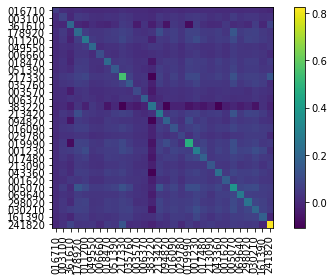

In [ ]:
# 수익률의 공분산
from pypfopt import plotting

plotting.plot_covariance(S)

#### ver02> 종가에 결측값이 있는 종목을 삭제한 df2로 포트폴리오 구성 ( 27개 종목 )

In [ ]:
# Calculate the expected annualized returns
# 복리 연평균 수익률
# return (1 + returns).prod() ** (frequency / returns.count()) - 1
mu2 = expected_returns.mean_historical_return(df2) 

# Calculate the annualized sample covariance matrix of the daily asset returns
S2 = risk_models.sample_cov(df2)

In [ ]:
mu2

016710    0.733610
003100    0.323117
178920    0.039989
011200    1.176861
049550    0.345546
006660    0.367212
018470    0.073267
051390    0.141308
035760   -0.090049
003570    0.202757
006370    0.126798
213420    0.560754
094820    0.286213
016090    0.034873
029780   -0.002890
019990    0.325008
001230    0.426336
017480    0.154359
213090    0.123475
043360    0.232085
001620   -0.015314
005070    0.212140
069640    0.154612
298020    0.620819
030210    0.319452
161390    0.043772
241820    0.635431
dtype: float64

In [ ]:
len(mu2)

27

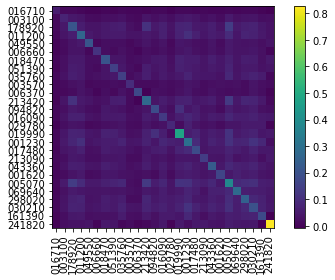

In [ ]:
# 수익률의 공분산
from pypfopt import plotting

plotting.plot_covariance(S2)

In [ ]:
S2.shape

(27, 27)

In [ ]:
len(S2)

27

In [ ]:
S2

,016710,003100,178920,011200,049550,006660,018470,051390,035760,003570,006370,213420,094820,016090,029780,019990,001230,017480,213090,043360,001620,005070,069640,298020,030210,161390,241820
016710,0.056720,0.014469,0.012163,0.006034,0.001991,0.002126,0.008085,0.005054,0.009125,0.006950,0.006806,0.003724,0.009483,0.011674,0.002097,0.010150,0.011851,0.008644,0.009879,0.007346,0.007091,0.010940,0.006989,0.011179,0.010129,0.002665,-0.003861
003100,0.014469,0.074582,0.045641,0.038137,0.019511,0.016656,0.027968,0.026144,0.033032,0.015488,0.012487,0.039990,0.026984,0.036395,0.023428,0.042671,0.047981,0.040796,0.022876,0.033354,0.018938,0.052459,0.029049,0.037777,0.038365,0.022451,0.025890
178920,0.012163,0.045641,0.213626,0.060754,0.036648,0.036302,0.048243,0.056394,0.061846,0.029028,0.019103,0.111520,0.049888,0.064783,0.035556,0.076190,0.077574,0.049384,0.046082,0.061329,0.035701,0.140699,0.053882,0.067025,0.071363,0.046027,0.032722
011200,0.006034,0.038137,0.060754,0.268204,0.048849,0.036912,0.049156,0.053916,0.052917,0.035335,0.036540,0.048306,0.038478,0.065326,0.034657,0.072453,0.106198,0.065403,0.042508,0.058742,0.048920,0.096135,0.043311,0.076706,0.068459,0.050700,0.034256
049550,0.001991,0.019511,0.036648,0.048849,0.210545,0.009901,0.023537,0.024194,0.023617,0.014468,0.023199,0.039684,0.023698,0.036033,0.014907,0.044315,0.035607,0.025441,0.023231,0.040709,0.019804,0.049233,0.037571,0.032855,0.037496,0.025881,0.040537
006660,0.002126,0.016656,0.036302,0.036912,0.009901,0.113468,0.024150,0.017059,0.029105,0.016202,0.008098,0.026865,0.018767,0.030594,0.016300,0.035953,0.047077,0.029286,0.021792,0.035572,0.022746,0.048808,0.037078,0.037362,0.042540,0.030709,0.006212
018470,0.008085,0.027968,0.048243,0.049156,0.023537,0.024150,0.210348,0.040256,0.040286,0.019264,0.024967,0.033848,0.046826,0.048103,0.028230,0.069901,0.057503,0.056018,0.039254,0.063855,0.043293,0.065957,0.039300,0.059085,0.056882,0.030217,0.050584
051390,0.005054,0.026144,0.056394,0.053916,0.024194,0.017059,0.040256,0.151410,0.045439,0.023778,0.014848,0.058395,0.039916,0.049039,0.030337,0.064964,0.055918,0.049565,0.039908,0.054220,0.042637,0.074369,0.037756,0.049491,0.049465,0.034105,0.040935
035760,0.009125,0.033032,0.061846,0.052917,0.023617,0.029105,0.040286,0.045439,0.150753,0.021091,0.033168,0.062449,0.033569,0.051948,0.035897,0.048635,0.075946,0.044601,0.041465,0.042760,0.034052,0.086357,0.040508,0.058543,0.070722,0.056039,0.009760
003570,0.006950,0.015488,0.029028,0.035335,0.014468,0.016202,0.019264,0.023778,0.021091,0.097012,0.017731,0.017544,0.017989,0.028055,0.019738,0.027580,0.039513,0.032699,0.021549,0.027490,0.031242,0.026712,0.029518,0.018619,0.038645,0.028115,0.018585


# 포트폴리오 최적화 ( Max.샤프비율 )

#### ver01> 결측값 삭제하지 않음 / df / mu, S / ef, cleaned_weights ( 30개 종목 )

In [ ]:
# Optimize for the maximal Sharpe ratio
ef = EfficientFrontier(mu, S)  # Create the Efficient Frontier Object

# Maximize the Sharpe ratio, and get the raw weights
# max_sharpe()-> optimizes for maximal Sharpe ratio (a.k.a the tangency portfolio)
# 결과값 : CML(자본시장선)과 효율적 투자선(efficient frontier)의 접점에 있는 포트폴리오
weights = ef.max_sharpe()

# clean_weights()-> rounds the weights and clips near-zeros.
# weights < 0.0001 => clean_weights = 0
# cleaned_weights => 소숫점 5자리까지 표시
cleaned_weights = ef.clean_weights()
print(cleaned_weights)

# calculates the expected return, volatility and Sharpe ratio for the optimized portfolio.
ef.portfolio_performance(verbose=True)

OrderedDict([('016710', 0.0), ('003100', 0.0), ('361610', 0.26508), ('178920', 0.0), ('011200', 0.0), ('049550', 0.0), ('006660', 0.0), ('018470', 0.0), ('051390', 0.0), ('217330', 0.00555), ('035760', 0.0), ('003570', 0.1514), ('006370', 0.0), ('383220', 0.28181), ('213420', 0.0), ('094820', 0.20726), ('016090', 0.0), ('029780', 0.0), ('019990', 0.02049), ('001230', 0.0), ('017480', 0.0), ('213090', 0.0), ('043360', 0.06841), ('001620', 0.0), ('005070', 0.0), ('069640', 0.0), ('298020', 0.0), ('030210', 0.0), ('161390', 0.0), ('241820', 0.0)])
Expected annual return: 238.9%
Annual volatility: 12.4%
Sharpe Ratio: 19.13


(2.3890972914731083, 0.12385293828723035, 19.1283091401423)

In [ ]:
weights

OrderedDict([('016710', 0.0),
             ('003100', 0.0),
             ('361610', 0.2650758967738382),
             ('178920', 0.0),
             ('011200', 0.0),
             ('049550', 0.0),
             ('006660', 0.0),
             ('018470', 0.0),
             ('051390', 0.0),
             ('217330', 0.0055472441669535),
             ('035760', 0.0),
             ('003570', 0.151402585556296),
             ('006370', 0.0),
             ('383220', 0.2818110152639811),
             ('213420', 0.0),
             ('094820', 0.2072575715327762),
             ('016090', 0.0),
             ('029780', 0.0),
             ('019990', 0.0204911984924665),
             ('001230', 0.0),
             ('017480', 0.0),
             ('213090', 0.0),
             ('043360', 0.0684144882136886),
             ('001620', 0.0),
             ('005070', 0.0),
             ('069640', 0.0),
             ('298020', 0.0),
             ('030210', 0.0),
             ('161390', 0.0),
             ('241820', 0.

In [ ]:
len(weights)

30

In [ ]:
cleaned_weights

OrderedDict([('016710', 0.0),
             ('003100', 0.0),
             ('361610', 0.26508),
             ('178920', 0.0),
             ('011200', 0.0),
             ('049550', 0.0),
             ('006660', 0.0),
             ('018470', 0.0),
             ('051390', 0.0),
             ('217330', 0.00555),
             ('035760', 0.0),
             ('003570', 0.1514),
             ('006370', 0.0),
             ('383220', 0.28181),
             ('213420', 0.0),
             ('094820', 0.20726),
             ('016090', 0.0),
             ('029780', 0.0),
             ('019990', 0.02049),
             ('001230', 0.0),
             ('017480', 0.0),
             ('213090', 0.0),
             ('043360', 0.06841),
             ('001620', 0.0),
             ('005070', 0.0),
             ('069640', 0.0),
             ('298020', 0.0),
             ('030210', 0.0),
             ('161390', 0.0),
             ('241820', 0.0)])

In [ ]:
len(cleaned_weights)

30

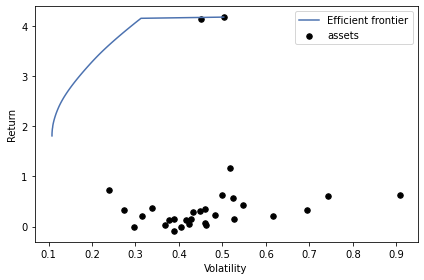

In [ ]:
# 효율적 투자선와 각 종목의 수익률 & 변동성
import matplotlib.pyplot as plt

ef = EfficientFrontier(mu, S, solver='SCS')

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
plt.legend(loc='best')
plt.show()

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


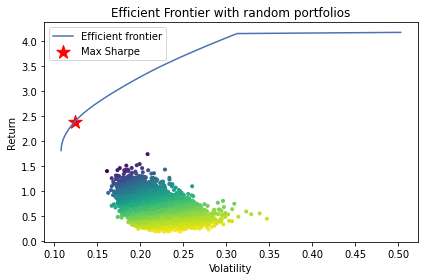

In [ ]:
# Show Efficient Frontier
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Minimize.volatility
# ef.min_volatility()
# ret_minv, std_minv, _ = ef.portfolio_performance()
# ax.scatter(std_minv, ret_minv, marker="*", s=100, c="b", label="Min Volatility")

# Find the tangency portfolio
ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()  # 기대수익률 , Risk(변동성)
ax.scatter(std_tangent, ret_tangent, marker="*", s=200, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 20000
w = np.random.dirichlet(np.ones(len(mu)), n_samples) # 난수로 20000세트의 투자비중 만들기
rets = w.dot(mu)                                     # 기대수익률
stds = np.sqrt(np.diag(w @ S @ w.T))                 # Risk(변동성)
sharpes = rets / stds                                # 샤프비율

ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend(loc='best')
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

In [ ]:
# Max.Sharpe Ratio로 최적화한 포트폴리오의 수익률과 변동성, 샤프비율
ef.portfolio_performance(verbose=True)

Expected annual return: 238.9%
Annual volatility: 12.4%
Sharpe Ratio: 19.14


(2.389454403537314, 0.12377699648455266, 19.142930195700952)

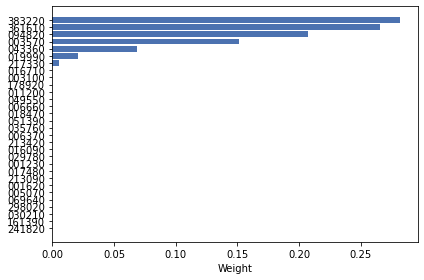

In [ ]:
# 종목별 투자비중
plotting.plot_weights(weights, ax=None)

#### ver02> 결측값 삭제 / df2 / mu2, S2 / ef2, cleaned_weights2 ( 27개 종목 )

In [ ]:
# Optimize for the maximal Sharpe ratio
ef2 = EfficientFrontier(mu2, S2)  # Create the Efficient Frontier Object

# Maximize the Sharpe ratio, and get the raw weights
# max_sharpe()-> optimizes for maximal Sharpe ratio (a.k.a the tangency portfolio)
# 결과값 : CML(자본시장선)과 효율적 투자선(efficient frontier)의 접점에 있는 포트폴리오
weights2 = ef2.max_sharpe()

# clean_weights()-> rounds the weights and clips near-zeros.
# weights < 0.0001 => clean_weights = 0
# cleaned_weights => 소숫점 5자리까지 표시
cleaned_weights2 = ef2.clean_weights()
print(cleaned_weights2)

# calculates the expected return, volatility and Sharpe ratio for the optimized portfolio.
ef2.portfolio_performance(verbose=True)

OrderedDict([('016710', 0.63965), ('003100', 0.0), ('178920', 0.0), ('011200', 0.18623), ('049550', 0.01229), ('006660', 0.07207), ('018470', 0.0), ('051390', 0.0), ('035760', 0.0), ('003570', 0.0), ('006370', 0.0), ('213420', 0.05008), ('094820', 0.0), ('016090', 0.0), ('029780', 0.0), ('019990', 0.0), ('001230', 0.0), ('017480', 0.0), ('213090', 0.0), ('043360', 0.0), ('001620', 0.0), ('005070', 0.0), ('069640', 0.0), ('298020', 0.00744), ('030210', 0.0), ('161390', 0.0), ('241820', 0.03223)])
Expected annual return: 77.2%
Annual volatility: 19.9%
Sharpe Ratio: 3.77


(0.7723183086871476, 0.19943410658070715, 3.7722650432547695)

In [ ]:
weights2

OrderedDict([('016710', 0.6396536459434476),
             ('003100', 0.0),
             ('178920', 0.0),
             ('011200', 0.1862287503388274),
             ('049550', 0.0122948949592081),
             ('006660', 0.0720683632199738),
             ('018470', 0.0),
             ('051390', 0.0),
             ('035760', 0.0),
             ('003570', 0.0),
             ('006370', 0.0),
             ('213420', 0.0500813078929186),
             ('094820', 0.0),
             ('016090', 0.0),
             ('029780', 0.0),
             ('019990', 0.0),
             ('001230', 0.0),
             ('017480', 0.0),
             ('213090', 0.0),
             ('043360', 0.0),
             ('001620', 0.0),
             ('005070', 0.0),
             ('069640', 0.0),
             ('298020', 0.0074409486938458),
             ('030210', 0.0),
             ('161390', 0.0),
             ('241820', 0.0322320889517787)])

In [ ]:
len(weights2)

27

In [ ]:
cleaned_weights2

OrderedDict([('016710', 0.63965),
             ('003100', 0.0),
             ('178920', 0.0),
             ('011200', 0.18623),
             ('049550', 0.01229),
             ('006660', 0.07207),
             ('018470', 0.0),
             ('051390', 0.0),
             ('035760', 0.0),
             ('003570', 0.0),
             ('006370', 0.0),
             ('213420', 0.05008),
             ('094820', 0.0),
             ('016090', 0.0),
             ('029780', 0.0),
             ('019990', 0.0),
             ('001230', 0.0),
             ('017480', 0.0),
             ('213090', 0.0),
             ('043360', 0.0),
             ('001620', 0.0),
             ('005070', 0.0),
             ('069640', 0.0),
             ('298020', 0.00744),
             ('030210', 0.0),
             ('161390', 0.0),
             ('241820', 0.03223)])

In [ ]:
len(cleaned_weights2)

27

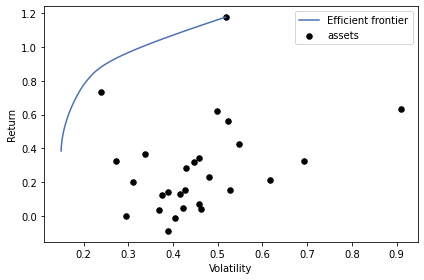

In [ ]:
# 효율적 투자선와 각 종목의 수익률 & 변동성
import matplotlib.pyplot as plt

ef2 = EfficientFrontier(mu2, S2, solver='SCS')

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef2, ax=ax, show_assets=True)
plt.legend(loc='best')
plt.show()

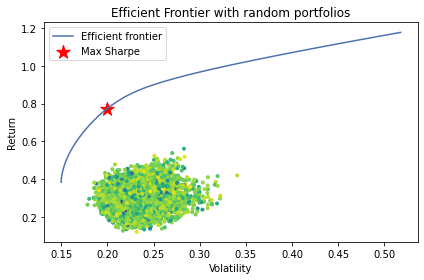

In [ ]:
# Show Efficient Frontier
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef2, ax=ax, show_assets=False)

# Minimize.volatility
# ef.min_volatility()
# ret_minv, std_minv, _ = ef.portfolio_performance()
# ax.scatter(std_minv, ret_minv, marker="*", s=100, c="b", label="Min Volatility")

# Find the tangency portfolio
ef2.max_sharpe()
ret_tangent2, std_tangent2, _ = ef2.portfolio_performance()  # 기대수익률 , Risk(변동성)
ax.scatter(std_tangent2, ret_tangent2, marker="*", s=200, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 20000
w2 = np.random.dirichlet(np.ones(len(mu2)), n_samples) # 난수로 20000세트의 투자비중 만들기
rets2 = w2.dot(mu2)                                     # 기대수익률
stds2 = np.sqrt(np.diag(w2 @ S2 @ w2.T))                 # Risk(변동성)
sharpes2 = rets2 / stds2                                # 샤프비율

ax.scatter(stds2, rets2, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend(loc='best')
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

In [ ]:
# Max.Sharpe Ratio로 최적화한 포트폴리오의 수익률과 변동성, 샤프비율
ef2.portfolio_performance(verbose=True)

Expected annual return: 77.2%
Annual volatility: 19.9%
Sharpe Ratio: 3.77


(0.7723053715026126, 0.19942129166508799, 3.772442577325439)

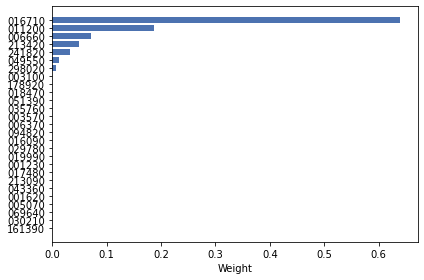

In [ ]:
# 종목별 투자비중
plotting.plot_weights(weights2, ax=None)

### 투자금액과 포트폴리오의 비중에 맞추어 수량 할당

In [ ]:
!pip install pulp

     |████████████████████████████████| 40.6 MB 32 kB/s 


#### ver01> 결측값 삭제하지 않음 / df / mu, S / ef, cleaned_weights ( 30개 종목 )

In [ ]:
# Get the discrete allocation of each sharpe per stock
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

# 투자금액 (단위: KRW)
portfolio_val = 15000000

latest_prices = get_latest_prices(df)

weights = cleaned_weights

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=portfolio_val)

allocation, leftover = da.lp_portfolio(verbose=False)

print('Discrete Allocaion: ', allocation)
print('Funds Remaining: ', leftover, ' KRW')

rmse = da._allocation_rmse_error(verbose=False)

Discrete Allocaion:  {'361610': 19, '217330': 1, '003570': 208, '383220': 8, '094820': 258, '019990': 25, '043360': 169}
Funds Remaining:  50.0  KRW
Allocation has RMSE: 0.001


In [ ]:
allocation

{'003570': 208,
 '019990': 25,
 '043360': 169,
 '094820': 258,
 '217330': 1,
 '361610': 19,
 '383220': 8}

In [ ]:
len(allocation)

7

#### ver02> 결측값 삭제하지 않음 / df2 / mu2, S2 / ef2, cleaned_weights2 /  ( 27개 종목 )

In [ ]:
# Get the discrete allocation of each sharpe per stock
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

# 투자금액 (단위: KRW)
portfolio_val = 15000000

latest_prices2 = get_latest_prices(df2)

weights2 = cleaned_weights2

da2 = DiscreteAllocation(weights2, latest_prices2, total_portfolio_value=portfolio_val)

allocation2, leftover2 = da2.lp_portfolio(verbose=False)

print('Discrete Allocaion: ', allocation2)
print('Funds Remaining: ', leftover2, ' KRW')

rmse2 = da2._allocation_rmse_error(verbose=False)

Discrete Allocaion:  {'016710': 260, '011200': 64, '049550': 21, '006660': 41, '213420': 13, '241820': 10}
Funds Remaining:  2280.0  KRW
Allocation has RMSE: 0.002


In [ ]:
allocation2

{'006660': 41,
 '011200': 64,
 '016710': 260,
 '049550': 21,
 '213420': 13,
 '241820': 10}

In [ ]:
len(allocation2)

6

### 포트폴리오 결과로 보여줄 변수 저장

#### ver01> 결측값 삭제하지 않음 ( 30개 종목 )

In [ ]:
# 각 종목별 실제 투자 금액
inv_total_price = {}

for i in allocation.keys():
  inv_total_price[i] = latest_prices.loc[i]*allocation[i]
inv_total_price

{'003570': 2256800.0,
 '019990': 278750.0,
 '043360': 980200.0,
 '094820': 3108900.0,
 '217330': 54300.0,
 '361610': 4009000.0,
 '383220': 4312000.0}

In [ ]:
inv_total_price['003570']

2256800.0

In [ ]:
# 총 투자금액
investment = 0

for i in inv_total_price.values():
    investment += i
print(investment)

14999950.0


In [ ]:
portfolio_val-leftover

14999950.0

In [ ]:
# 각 종목별 실제 투자 비중
inv_total_weight = {}

for i in allocation.keys():
  inv_total_weight[i] = inv_total_price[i]/investment
inv_total_weight

{'003570': 0.15045383484611616,
 '019990': 0.01858339527798426,
 '043360': 0.06534688448961497,
 '094820': 0.20726069086896956,
 '217330': 0.003620012066706889,
 '361610': 0.2672675575585252,
 '383220': 0.287467624892083}

In [ ]:
# 투자비중의 합계
investment_w = 0

for i in inv_total_weight.values():
    investment_w += i
print(investment_w)

1.0


In [ ]:
# 결과값으로 불러올 값을 리스트로 저장
name_list = []                    # 종목명(회사이름)
total_price_stock =[]             # 각 종목별 실제 투자 금액
total_weight_stock = []           # 각 종목별 실제 투자 비중

for i in allocation.keys(): # i = 포트폴리오에 할당된 종목의 종목코드
    name_list.append(code_name_dict.get(i))
    total_price_stock.append(inv_total_price.get(i))
    total_weight_stock.append(inv_total_weight.get(i))

In [ ]:
name_list

['SK아이이테크놀로지', '싸이토젠', 'SNT중공업', 'F&F', '일진파워', '에너토크', '디지아이']

In [ ]:
total_price_stock

[4009000.0, 54300.0, 2256800.0, 4312000.0, 3108900.0, 278750.0, 980200.0]

In [ ]:
total_weight_stock

[0.2672675575585252,
 0.003620012066706889,
 0.15045383484611616,
 0.287467624892083,
 0.20726069086896956,
 0.01858339527798426,
 0.06534688448961497]

In [ ]:
# Get the discrete allocation values
discrete_allocation_list = []
for symbol in allocation:
  discrete_allocation_list.append(allocation.get(symbol))

In [ ]:
discrete_allocation_list

[19, 1, 208, 8, 258, 25, 169]

In [ ]:
# Create a dataframe for the portfolio
portfolio_df = pd.DataFrame(columns = ['종목명','종목코드','수량(주)', '투자금액(원)','투자비중'])
portfolio_df

,종목명,종목코드,수량(주),투자금액(원),투자비중


In [ ]:
# portfolio_df['Company_name'] = company_name
portfolio_df['종목명'] = name_list
portfolio_df['종목코드'] = allocation
portfolio_df['수량(주)'] = discrete_allocation_list
portfolio_df['투자금액(원)'] = total_price_stock
portfolio_df['투자비중'] = total_weight_stock

In [ ]:
portfolio_df

,종목명,종목코드,수량(주),투자금액(원),투자비중
0,SK아이이테크놀로지,361610,19,4009000.0,0.267268
1,싸이토젠,217330,1,54300.0,0.003620
2,SNT중공업,003570,208,2256800.0,0.150454
3,F&F,383220,8,4312000.0,0.287468
4,일진파워,094820,258,3108900.0,0.207261
5,에너토크,019990,25,278750.0,0.018583
6,디지아이,043360,169,980200.0,0.065347


In [ ]:
# Sort by allocation & Show the portfolio
portfolio_df_sorted = portfolio_df.sort_values('투자비중', ascending = False)
portfolio_df_sorted = portfolio_df_sorted.reset_index(drop=True)
portfolio_df_sorted

,종목명,종목코드,수량(주),투자금액(원),투자비중
0,F&F,383220,8,4312000.0,0.287468
1,SK아이이테크놀로지,361610,19,4009000.0,0.267268
2,일진파워,094820,258,3108900.0,0.207261
3,SNT중공업,003570,208,2256800.0,0.150454
4,디지아이,043360,169,980200.0,0.065347
5,에너토크,019990,25,278750.0,0.018583
6,싸이토젠,217330,1,54300.0,0.003620


### 투자 금액에 따라 최적화된 포트폴리오의 종목별 수량

In [ ]:
portfolio_df_sorted.loc["합계",2:] = portfolio_df_sorted.sum()
portfolio_df_sorted

,종목명,종목코드,수량(주),투자금액(원),투자비중
0,F&F,383220,8.0,4312000.0,0.287468
1,SK아이이테크놀로지,361610,19.0,4009000.0,0.267268
2,일진파워,094820,258.0,3108900.0,0.207261
3,SNT중공업,003570,208.0,2256800.0,0.150454
4,디지아이,043360,169.0,980200.0,0.065347
5,에너토크,019990,25.0,278750.0,0.018583
6,싸이토젠,217330,1.0,54300.0,0.003620
합계,NaN,NaN,688.0,14999950.0,1.000000


#### ver02> 결측값 삭제 ( 27개 종목 )

In [ ]:
# 각 종목별 실제 투자 금액
inv_total_price2 = {}

for i in allocation2.keys():
  inv_total_price2[i] = latest_prices2.loc[i]*allocation2[i]
inv_total_price2

{'006660': 1102900,
 '011200': 2809600,
 '016710': 9620000,
 '049550': 181020,
 '213420': 772200,
 '241820': 512000}

In [ ]:
inv_total_price2['006660']

1102900

In [ ]:
# 총 투자금액
investment2 = 0

for i in inv_total_price2.values():
    investment2 += i
print(investment2)

14997720


In [ ]:
portfolio_val-leftover2

14997720.0

In [ ]:
# 각 종목별 실제 투자 비중
inv_total_weight2 = {}

for i in allocation2.keys():
  inv_total_weight2[i] = inv_total_price2[i]/investment2
inv_total_weight2

{'006660': 0.07353784441901835,
 '011200': 0.18733514160819112,
 '016710': 0.6414308308196179,
 '049550': 0.012069834614861458,
 '213420': 0.051487826149574735,
 '241820': 0.03413852238873642}

In [ ]:
# 투자비중의 합계
investment_w2 = 0

for i in inv_total_weight2.values():
    investment_w2 += i
print(investment_w2)

0.9999999999999999


In [ ]:
# 결과값으로 불러올 값을 리스트로 저장
name_list2 = []                    # 종목명(회사이름)
total_price_stock2 =[]             # 각 종목별 실제 투자 금액
total_weight_stock2 = []           # 각 종목별 실제 투자 비중

for i in allocation2.keys(): # i = 포트폴리오에 할당된 종목의 종목코드
    name_list2.append(code_name_dict.get(i))
    total_price_stock2.append(inv_total_price2.get(i))
    total_weight_stock2.append(inv_total_weight2.get(i))

In [ ]:
name_list2

['대성홀딩스', 'HMM', '잉크테크', '삼성공조', '덕산네오룩스', '피씨엘']

In [ ]:
total_price_stock2

[9620000, 2809600, 181020, 1102900, 772200, 512000]

In [ ]:
total_weight_stock2

[0.6414308308196179,
 0.18733514160819112,
 0.012069834614861458,
 0.07353784441901835,
 0.051487826149574735,
 0.03413852238873642]

In [ ]:
# Get the discrete allocation values
discrete_allocation_list2 = []
for symbol in allocation2:
  discrete_allocation_list2.append(allocation2.get(symbol))

In [ ]:
discrete_allocation_list2

[260, 64, 21, 41, 13, 10]

In [ ]:
# Create a dataframe for the portfolio
portfolio_df2 = pd.DataFrame(columns = ['종목명','종목코드','수량(주)', '투자금액(원)','투자비중'])
portfolio_df2

,종목명,종목코드,수량(주),투자금액(원),투자비중


In [ ]:
# portfolio_df['Company_name'] = company_name
portfolio_df2['종목명'] = name_list2
portfolio_df2['종목코드'] = allocation2
portfolio_df2['수량(주)'] = discrete_allocation_list2
portfolio_df2['투자금액(원)'] = total_price_stock2
portfolio_df2['투자비중'] = total_weight_stock2

In [ ]:
portfolio_df2

,종목명,종목코드,수량(주),투자금액(원),투자비중
0,대성홀딩스,016710,260,9620000,0.641431
1,HMM,011200,64,2809600,0.187335
2,잉크테크,049550,21,181020,0.012070
3,삼성공조,006660,41,1102900,0.073538
4,덕산네오룩스,213420,13,772200,0.051488
5,피씨엘,241820,10,512000,0.034139


In [ ]:
# Sort by allocation & Show the portfolio
portfolio_df_sorted2 = portfolio_df2.sort_values('투자비중', ascending = False)
portfolio_df_sorted2 = portfolio_df_sorted2.reset_index(drop=True)
portfolio_df_sorted2

,종목명,종목코드,수량(주),투자금액(원),투자비중
0,대성홀딩스,016710,260,9620000,0.641431
1,HMM,011200,64,2809600,0.187335
2,삼성공조,006660,41,1102900,0.073538
3,덕산네오룩스,213420,13,772200,0.051488
4,피씨엘,241820,10,512000,0.034139
5,잉크테크,049550,21,181020,0.012070


### 투자 금액에 따라 최적화된 포트폴리오의 종목별 수량

In [ ]:
portfolio_df_sorted2.loc["합계",2:] = portfolio_df_sorted2.sum()
portfolio_df_sorted2

,종목명,종목코드,수량(주),투자금액(원),투자비중
0,대성홀딩스,016710,260.0,9620000.0,0.641431
1,HMM,011200,64.0,2809600.0,0.187335
2,삼성공조,006660,41.0,1102900.0,0.073538
3,덕산네오룩스,213420,13.0,772200.0,0.051488
4,피씨엘,241820,10.0,512000.0,0.034139
5,잉크테크,049550,21.0,181020.0,0.012070
합계,NaN,NaN,409.0,14997720.0,1.000000


# 포트폴리오의 수익률과 변동성을 벤치마크지수(KOSPI)와 비교

#### ver01> 결측값 삭제 ( 30개 종목 )

In [ ]:
df

,016710,003100,361610,178920,011200,049550,006660,018470,051390,217330,035760,003570,006370,383220,213420,094820,016090,029780,019990,001230,017480,213090,043360,001620,005070,069640,298020,030210,161390,241820
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-07-19,7370,19600,NaN,51700,4485,3610,10750,1085,3390,NaN,230000,6314,9900,NaN,16100,5760,2695,35500,4885,7130,4805,8920,3145,1130,24431,8200,214000,3575,43700,12100
2018-07-20,7360,19700,NaN,52400,4460,3665,10500,1055,3370,NaN,223100,6294,10000,NaN,16200,5660,2620,36450,4845,7030,4690,9000,3520,1125,23888,8250,208000,3575,43350,13150
2018-07-23,7220,19000,NaN,50400,4285,3565,10650,1030,3305,NaN,223100,6353,9900,NaN,15950,5630,2430,36850,4595,7350,4555,8900,3395,1050,22440,8190,198500,3420,43750,12400
2018-07-24,7290,19450,NaN,49800,4445,3480,10600,1030,3340,NaN,224000,6284,9780,NaN,15750,6140,2425,37050,4685,7510,4805,8970,3340,1050,23164,8270,205500,3520,42900,12400
2018-07-25,7170,19300,NaN,50900,4410,3465,10600,1015,3310,NaN,224500,6265,9630,NaN,15150,6060,2455,37050,4690,7480,4770,8740,3320,1055,23164,8280,207000,3630,44350,11550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-13,37150,44200,211500.0,55600,43500,8580,26300,1045,4935,55000.0,179900,10600,13500,548000.0,59000,11850,3040,34750,11400,21100,7540,12700,4360,1150,32500,12400,906000,8450,51800,56300
2021-07-14,36900,44200,209000.0,55100,42900,8540,26500,1085,4900,55100.0,174900,10700,13950,549000.0,59400,11850,3000,35000,11350,20750,7470,12850,5660,1135,37450,14000,898000,8560,50800,55600
2021-07-15,37100,44300,204500.0,55400,43100,8520,26700,1410,4960,54400.0,179100,10750,13900,545000.0,60000,12350,3015,35150,11500,21150,7570,12950,6480,1160,37400,13100,935000,8470,51400,54000


In [ ]:
cleaned_weights

OrderedDict([('016710', 0.0),
             ('003100', 0.0),
             ('361610', 0.26508),
             ('178920', 0.0),
             ('011200', 0.0),
             ('049550', 0.0),
             ('006660', 0.0),
             ('018470', 0.0),
             ('051390', 0.0),
             ('217330', 0.00555),
             ('035760', 0.0),
             ('003570', 0.1514),
             ('006370', 0.0),
             ('383220', 0.28181),
             ('213420', 0.0),
             ('094820', 0.20726),
             ('016090', 0.0),
             ('029780', 0.0),
             ('019990', 0.02049),
             ('001230', 0.0),
             ('017480', 0.0),
             ('213090', 0.0),
             ('043360', 0.06841),
             ('001620', 0.0),
             ('005070', 0.0),
             ('069640', 0.0),
             ('298020', 0.0),
             ('030210', 0.0),
             ('161390', 0.0),
             ('241820', 0.0)])

In [ ]:
len(cleaned_weights)

30

In [ ]:
# 각 일자별, 종목별 종가에 해당 weights를 곱해주기
for i, weight in cleaned_weights.items():
    df[i] = df[i]*weight

In [ ]:
df

,016710,003100,361610,178920,011200,049550,006660,018470,051390,217330,035760,003570,006370,383220,213420,094820,016090,029780,019990,001230,017480,213090,043360,001620,005070,069640,298020,030210,161390,241820
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-07-19,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,955.9396,0.0,NaN,0.0,1193.8176,0.0,0.0,100.09365,0.0,0.0,0.0,215.14945,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-07-20,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,952.9116,0.0,NaN,0.0,1173.0916,0.0,0.0,99.27405,0.0,0.0,0.0,240.80320,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-07-23,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,961.8442,0.0,NaN,0.0,1166.8738,0.0,0.0,94.15155,0.0,0.0,0.0,232.25195,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-07-24,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,951.3976,0.0,NaN,0.0,1272.5764,0.0,0.0,95.99565,0.0,0.0,0.0,228.48940,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-07-25,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,948.5210,0.0,NaN,0.0,1255.9956,0.0,0.0,96.09810,0.0,0.0,0.0,227.12120,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-13,0.0,0.0,56064.42,0.0,0.0,0.0,0.0,0.0,0.0,305.250,0.0,1604.8400,0.0,154431.88,0.0,2456.0310,0.0,0.0,233.58600,0.0,0.0,0.0,298.26760,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-07-14,0.0,0.0,55401.72,0.0,0.0,0.0,0.0,0.0,0.0,305.805,0.0,1619.9800,0.0,154713.69,0.0,2456.0310,0.0,0.0,232.56150,0.0,0.0,0.0,387.20060,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-07-15,0.0,0.0,54208.86,0.0,0.0,0.0,0.0,0.0,0.0,301.920,0.0,1627.5500,0.0,153586.45,0.0,2559.6610,0.0,0.0,235.63500,0.0,0.0,0.0,443.29680,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# 일자별 종목의 (종가*비중) 합계를 Port열에 저장
df['Port'] = df.sum(axis = 1)
df

,016710,003100,361610,178920,011200,049550,006660,018470,051390,217330,035760,003570,006370,383220,213420,094820,016090,029780,019990,001230,017480,213090,043360,001620,005070,069640,298020,030210,161390,241820,Port
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-07-19,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,955.9396,0.0,NaN,0.0,1193.8176,0.0,0.0,100.09365,0.0,0.0,0.0,215.14945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2465.00030
2018-07-20,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,952.9116,0.0,NaN,0.0,1173.0916,0.0,0.0,99.27405,0.0,0.0,0.0,240.80320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2466.08045
2018-07-23,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,961.8442,0.0,NaN,0.0,1166.8738,0.0,0.0,94.15155,0.0,0.0,0.0,232.25195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2455.12150
2018-07-24,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,951.3976,0.0,NaN,0.0,1272.5764,0.0,0.0,95.99565,0.0,0.0,0.0,228.48940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2548.45905
2018-07-25,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,948.5210,0.0,NaN,0.0,1255.9956,0.0,0.0,96.09810,0.0,0.0,0.0,227.12120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2527.73590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-13,0.0,0.0,56064.42,0.0,0.0,0.0,0.0,0.0,0.0,305.250,0.0,1604.8400,0.0,154431.88,0.0,2456.0310,0.0,0.0,233.58600,0.0,0.0,0.0,298.26760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,215394.27460
2021-07-14,0.0,0.0,55401.72,0.0,0.0,0.0,0.0,0.0,0.0,305.805,0.0,1619.9800,0.0,154713.69,0.0,2456.0310,0.0,0.0,232.56150,0.0,0.0,0.0,387.20060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,215116.98810
2021-07-15,0.0,0.0,54208.86,0.0,0.0,0.0,0.0,0.0,0.0,301.920,0.0,1627.5500,0.0,153586.45,0.0,2559.6610,0.0,0.0,235.63500,0.0,0.0,0.0,443.29680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,212963.37280


In [ ]:
# 일자별 종가의 전일대비 변동률(수익률)을 portfolio라는 데이터프레임으로 저장
portfolio = df[['Port']].pct_change()
portfolio

,Port
Date,
2018-07-19,NaN
2018-07-20,0.000438
2018-07-23,-0.004444
2018-07-24,0.038017
2018-07-25,-0.008132
...,...
2021-07-13,0.018806
2021-07-14,-0.001287
2021-07-15,-0.010011


In [ ]:
# 코스피지수 불러오기
kospi = fdr.DataReader('KS11', start_date, end_date)[['Close']]
kospi

,Close
Date,
2018-07-19,2282.29
2018-07-20,2289.19
2018-07-23,2269.31
2018-07-24,2280.20
2018-07-25,2273.03
...,...
2021-07-13,3271.38
2021-07-14,3264.81
2021-07-15,3286.22


In [ ]:
# 코스피지수의 변동률(수익률) 구하기
# 변동률(수익률) = (당일가격-전일가격) / 전일가격
# 7/20의 변동률(수익률) = (7/20 가격-7-19 가격) / 7/19 가격
kospi_pct = kospi.pct_change()
kospi_pct

,Close
Date,
2018-07-19,NaN
2018-07-20,0.003023
2018-07-23,-0.008684
2018-07-24,0.004799
2018-07-25,-0.003144
...,...
2021-07-13,0.007673
2021-07-14,-0.002008
2021-07-15,0.006558


In [ ]:
# 코스피와 포트폴리오 합치기
result = kospi_pct.join(portfolio)
result

,Close,Port
Date,,
2018-07-19,NaN,NaN
2018-07-20,0.003023,0.000438
2018-07-23,-0.008684,-0.004444
2018-07-24,0.004799,0.038017
2018-07-25,-0.003144,-0.008132
...,...,...
2021-07-13,0.007673,0.018806
2021-07-14,-0.002008,-0.001287
2021-07-15,0.006558,-0.010011


In [ ]:
# 1열을 0으로 
result.iloc[0] = 0
result

,Close,Port
Date,,
2018-07-19,0.000000,0.000000
2018-07-20,0.003023,0.000438
2018-07-23,-0.008684,-0.004444
2018-07-24,0.004799,0.038017
2018-07-25,-0.003144,-0.008132
...,...,...
2021-07-13,0.007673,0.018806
2021-07-14,-0.002008,-0.001287
2021-07-15,0.006558,-0.010011


In [ ]:
# 열 이름 변경
result.columns = ['KOSPI', 'PORTFOLIO']
result

,KOSPI,PORTFOLIO
Date,,
2018-07-19,0.000000,0.000000
2018-07-20,0.003023,0.000438
2018-07-23,-0.008684,-0.004444
2018-07-24,0.004799,0.038017
2018-07-25,-0.003144,-0.008132
...,...,...
2021-07-13,0.007673,0.018806
2021-07-14,-0.002008,-0.001287
2021-07-15,0.006558,-0.010011


In [ ]:
# 1에서 시작해서, 전일대비 변동률(수익률)을 적용하여 수치화하기
wealth = (1+result).cumprod()
wealth

,KOSPI,PORTFOLIO
Date,,
2018-07-19,1.000000,1.000000
2018-07-20,1.003023,1.000438
2018-07-23,0.994313,0.995992
2018-07-24,0.999084,1.033858
2018-07-25,0.995943,1.025451
...,...,...
2021-07-13,1.433376,87.381034
2021-07-14,1.430497,87.268544
2021-07-15,1.439878,86.394867


## 시각화

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


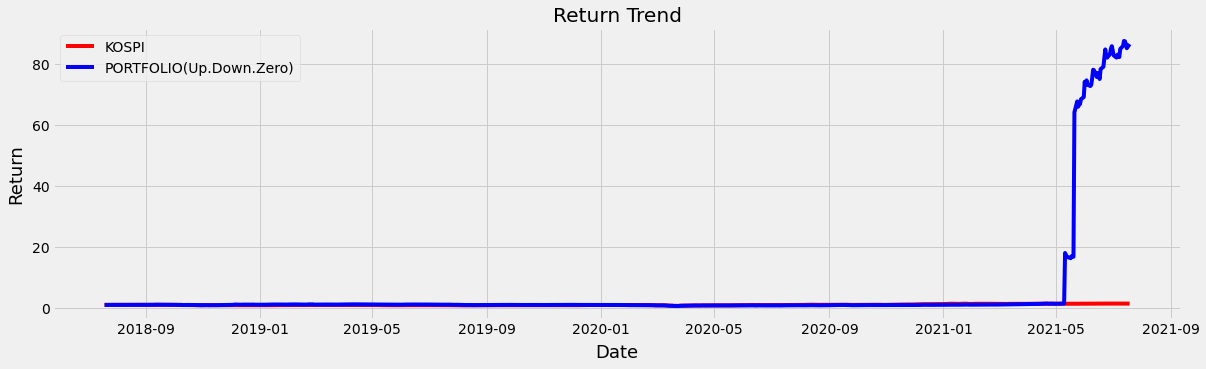

In [ ]:
# 포트폴리오와 KOSPI 지수의 '누적 수익률 추이'를 시각화하여 비교

# matplotlib.pyplot 스타일시트 설정
plt.style.use('fivethirtyeight')

plt.figure(figsize=(18,5))
plt.plot(wealth.index, wealth.KOSPI , 'r', label='KOSPI')
plt.plot(wealth.index, wealth.PORTFOLIO ,'b', label="PORTFOLIO(Up.Down.Zero)")
plt.grid(True)
plt.title('Return Trend')
plt.xlabel('Date',fontsize=18, labelpad=7)
plt.ylabel('Return',fontsize=18, labelpad=7)
plt.legend(loc='best')
plt.show()

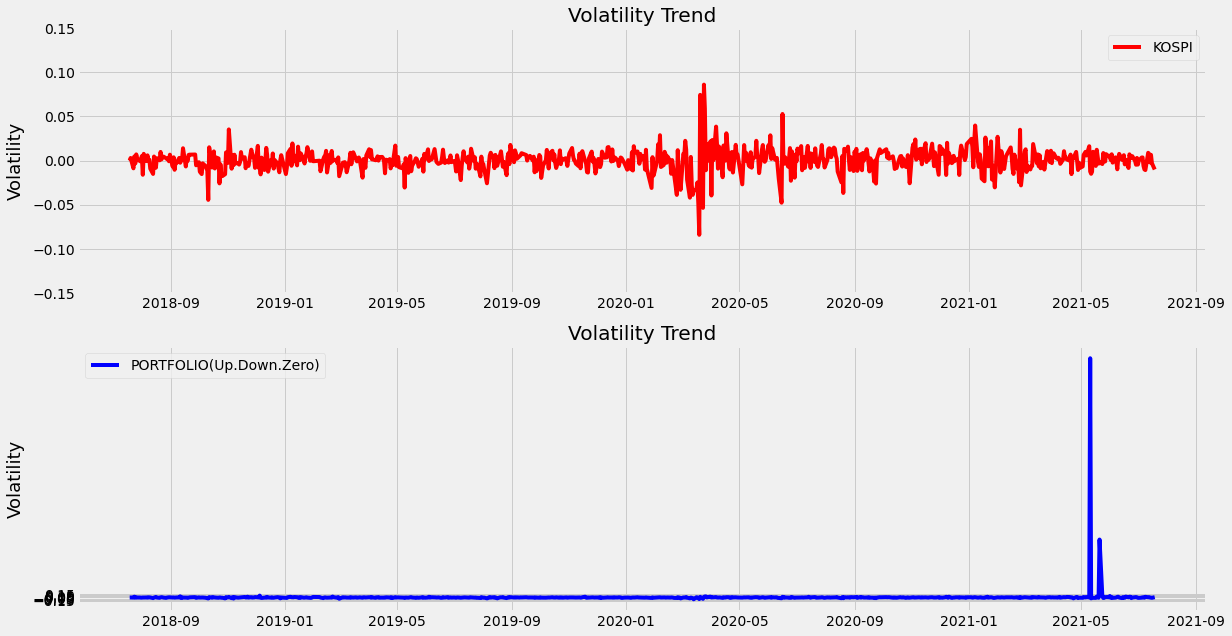

In [ ]:
# 변동률 비교
plt.figure(figsize=(18,10))

plt.subplot(2,1,1)
plt.title('Volatility Trend')

plt.plot(result.index, result.KOSPI , 'r', label='KOSPI')
plt.yticks([-0.15, -0.10, -0.05, 0.00, 0.05, 0.10, 0.15])
plt.grid(True)
plt.ylabel('Volatility',fontsize=18, labelpad=7)
plt.legend(loc='best')

plt.subplot(2,1,2)
plt.title('Volatility Trend')
plt.plot(result.index, result.PORTFOLIO ,'b', label="PORTFOLIO(Up.Down.Zero)")
# plt.yticks([-0.15, -0.10, -0.05, 0.00, 0.05, 0.10, 0.15])
plt.ylabel('Volatility',fontsize=18, labelpad=7)
plt.legend(loc='best')

plt.grid(True)
plt.show()

In [ ]:
portfolio_df_sorted

,종목명,종목코드,수량(주),투자금액(원),투자비중
0,F&F,383220,8,4312000.0,0.287468
1,SK아이이테크놀로지,361610,19,4009000.0,0.267268
2,일진파워,094820,258,3108900.0,0.207261
3,SNT중공업,003570,208,2256800.0,0.150454
4,디지아이,043360,169,980200.0,0.065347
5,에너토크,019990,25,278750.0,0.018583
6,싸이토젠,217330,1,54300.0,0.003620


#### ver02> 결측값 삭제 ( 27개 종목 )

In [ ]:
df2

,016710,003100,178920,011200,049550,006660,018470,051390,035760,003570,006370,213420,094820,016090,029780,019990,001230,017480,213090,043360,001620,005070,069640,298020,030210,161390,241820
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-07-19,7370,19600,51700,4485,3610,10750,1085,3390,230000,6314,9900,16100,5760,2695,35500,4885,7130,4805,8920,3145,1130,24431,8200,214000,3575,43700,12100
2018-07-20,7360,19700,52400,4460,3665,10500,1055,3370,223100,6294,10000,16200,5660,2620,36450,4845,7030,4690,9000,3520,1125,23888,8250,208000,3575,43350,13150
2018-07-23,7220,19000,50400,4285,3565,10650,1030,3305,223100,6353,9900,15950,5630,2430,36850,4595,7350,4555,8900,3395,1050,22440,8190,198500,3420,43750,12400
2018-07-24,7290,19450,49800,4445,3480,10600,1030,3340,224000,6284,9780,15750,6140,2425,37050,4685,7510,4805,8970,3340,1050,23164,8270,205500,3520,42900,12400
2018-07-25,7170,19300,50900,4410,3465,10600,1015,3310,224500,6265,9630,15150,6060,2455,37050,4690,7480,4770,8740,3320,1055,23164,8280,207000,3630,44350,11550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-13,37150,44200,55600,43500,8580,26300,1045,4935,179900,10600,13500,59000,11850,3040,34750,11400,21100,7540,12700,4360,1150,32500,12400,906000,8450,51800,56300
2021-07-14,36900,44200,55100,42900,8540,26500,1085,4900,174900,10700,13950,59400,11850,3000,35000,11350,20750,7470,12850,5660,1135,37450,14000,898000,8560,50800,55600
2021-07-15,37100,44300,55400,43100,8520,26700,1410,4960,179100,10750,13900,60000,12350,3015,35150,11500,21150,7570,12950,6480,1160,37400,13100,935000,8470,51400,54000


In [ ]:
cleaned_weights2

OrderedDict([('016710', 0.63965),
             ('003100', 0.0),
             ('178920', 0.0),
             ('011200', 0.18623),
             ('049550', 0.01229),
             ('006660', 0.07207),
             ('018470', 0.0),
             ('051390', 0.0),
             ('035760', 0.0),
             ('003570', 0.0),
             ('006370', 0.0),
             ('213420', 0.05008),
             ('094820', 0.0),
             ('016090', 0.0),
             ('029780', 0.0),
             ('019990', 0.0),
             ('001230', 0.0),
             ('017480', 0.0),
             ('213090', 0.0),
             ('043360', 0.0),
             ('001620', 0.0),
             ('005070', 0.0),
             ('069640', 0.0),
             ('298020', 0.00744),
             ('030210', 0.0),
             ('161390', 0.0),
             ('241820', 0.03223)])

In [ ]:
len(cleaned_weights2)

27

In [ ]:
# 각 일자별, 종목별 종가에 해당 weights를 곱해주기
for i, weight in cleaned_weights2.items():
    df2[i] = df2[i]*weight

In [ ]:
df2

,016710,003100,178920,011200,049550,006660,018470,051390,035760,003570,006370,213420,094820,016090,029780,019990,001230,017480,213090,043360,001620,005070,069640,298020,030210,161390,241820
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-07-19,4714.2205,0.0,0.0,835.24155,44.36690,774.7525,0.0,0.0,0.0,0.0,0.0,806.288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1592.16,0.0,0.0,389.9830
2018-07-20,4707.8240,0.0,0.0,830.58580,45.04285,756.7350,0.0,0.0,0.0,0.0,0.0,811.296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1547.52,0.0,0.0,423.8245
2018-07-23,4618.2730,0.0,0.0,797.99555,43.81385,767.5455,0.0,0.0,0.0,0.0,0.0,798.776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1476.84,0.0,0.0,399.6520
2018-07-24,4663.0485,0.0,0.0,827.79235,42.76920,763.9420,0.0,0.0,0.0,0.0,0.0,788.760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1528.92,0.0,0.0,399.6520
2018-07-25,4586.2905,0.0,0.0,821.27430,42.58485,763.9420,0.0,0.0,0.0,0.0,0.0,758.712,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1540.08,0.0,0.0,372.2565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-13,23762.9975,0.0,0.0,8101.00500,105.44820,1895.4410,0.0,0.0,0.0,0.0,0.0,2954.720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6740.64,0.0,0.0,1814.5490
2021-07-14,23603.0850,0.0,0.0,7989.26700,104.95660,1909.8550,0.0,0.0,0.0,0.0,0.0,2974.752,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6681.12,0.0,0.0,1791.9880
2021-07-15,23731.0150,0.0,0.0,8026.51300,104.71080,1924.2690,0.0,0.0,0.0,0.0,0.0,3004.800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6956.40,0.0,0.0,1740.4200


In [ ]:
# 일자별 종목의 (종가*비중) 합계를 Port열에 저장
df2['Port'] = df2.sum(axis = 1)
df2

,016710,003100,178920,011200,049550,006660,018470,051390,035760,003570,006370,213420,094820,016090,029780,019990,001230,017480,213090,043360,001620,005070,069640,298020,030210,161390,241820,Port
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-07-19,4714.2205,0.0,0.0,835.24155,44.36690,774.7525,0.0,0.0,0.0,0.0,0.0,806.288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1592.16,0.0,0.0,389.9830,9157.01245
2018-07-20,4707.8240,0.0,0.0,830.58580,45.04285,756.7350,0.0,0.0,0.0,0.0,0.0,811.296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1547.52,0.0,0.0,423.8245,9122.82815
2018-07-23,4618.2730,0.0,0.0,797.99555,43.81385,767.5455,0.0,0.0,0.0,0.0,0.0,798.776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1476.84,0.0,0.0,399.6520,8902.89590
2018-07-24,4663.0485,0.0,0.0,827.79235,42.76920,763.9420,0.0,0.0,0.0,0.0,0.0,788.760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1528.92,0.0,0.0,399.6520,9014.88405
2018-07-25,4586.2905,0.0,0.0,821.27430,42.58485,763.9420,0.0,0.0,0.0,0.0,0.0,758.712,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1540.08,0.0,0.0,372.2565,8885.14015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-13,23762.9975,0.0,0.0,8101.00500,105.44820,1895.4410,0.0,0.0,0.0,0.0,0.0,2954.720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6740.64,0.0,0.0,1814.5490,45374.80070
2021-07-14,23603.0850,0.0,0.0,7989.26700,104.95660,1909.8550,0.0,0.0,0.0,0.0,0.0,2974.752,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6681.12,0.0,0.0,1791.9880,45055.02360
2021-07-15,23731.0150,0.0,0.0,8026.51300,104.71080,1924.2690,0.0,0.0,0.0,0.0,0.0,3004.800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6956.40,0.0,0.0,1740.4200,45488.12780


In [ ]:
# 일자별 종가의 전일대비 변동률(수익률)을 portfolio라는 데이터프레임으로 저장
portfolio2 = df2[['Port']].pct_change()
portfolio2

,Port
Date,
2018-07-19,NaN
2018-07-20,-0.003733
2018-07-23,-0.024108
2018-07-24,0.012579
2018-07-25,-0.014392
...,...
2021-07-13,0.000939
2021-07-14,-0.007047
2021-07-15,0.009613


In [ ]:
# 코스피지수 불러오기
kospi = fdr.DataReader('KS11', start_date, end_date)[['Close']]
kospi

,Close
Date,
2018-07-19,2282.29
2018-07-20,2289.19
2018-07-23,2269.31
2018-07-24,2280.20
2018-07-25,2273.03
...,...
2021-07-13,3271.38
2021-07-14,3264.81
2021-07-15,3286.22


In [ ]:
# 코스피지수의 변동률(수익률) 구하기
# 변동률(수익률) = (당일가격-전일가격) / 전일가격
# 7/20의 변동률(수익률) = (7/20 가격-7-19 가격) / 7/19 가격
kospi_pct = kospi.pct_change()
kospi_pct

,Close
Date,
2018-07-19,NaN
2018-07-20,0.003023
2018-07-23,-0.008684
2018-07-24,0.004799
2018-07-25,-0.003144
...,...
2021-07-13,0.007673
2021-07-14,-0.002008
2021-07-15,0.006558


In [ ]:
# 코스피와 포트폴리오 합치기
result2 = kospi_pct.join(portfolio2)
result2

,Close,Port
Date,,
2018-07-19,NaN,NaN
2018-07-20,0.003023,-0.003733
2018-07-23,-0.008684,-0.024108
2018-07-24,0.004799,0.012579
2018-07-25,-0.003144,-0.014392
...,...,...
2021-07-13,0.007673,0.000939
2021-07-14,-0.002008,-0.007047
2021-07-15,0.006558,0.009613


In [ ]:
# 1열을 0으로 
result2.iloc[0] = 0
result2

,Close,Port
Date,,
2018-07-19,0.000000,0.000000
2018-07-20,0.003023,-0.003733
2018-07-23,-0.008684,-0.024108
2018-07-24,0.004799,0.012579
2018-07-25,-0.003144,-0.014392
...,...,...
2021-07-13,0.007673,0.000939
2021-07-14,-0.002008,-0.007047
2021-07-15,0.006558,0.009613


In [ ]:
# 열 이름 변경
result2.columns = ['KOSPI', 'PORTFOLIO']
result2

,KOSPI,PORTFOLIO
Date,,
2018-07-19,0.000000,0.000000
2018-07-20,0.003023,-0.003733
2018-07-23,-0.008684,-0.024108
2018-07-24,0.004799,0.012579
2018-07-25,-0.003144,-0.014392
...,...,...
2021-07-13,0.007673,0.000939
2021-07-14,-0.002008,-0.007047
2021-07-15,0.006558,0.009613


In [ ]:
# 1에서 시작해서, 전일대비 변동률(수익률)을 적용하여 수치화하기
wealth2 = (1+result2).cumprod()
wealth2

,KOSPI,PORTFOLIO
Date,,
2018-07-19,1.000000,1.000000
2018-07-20,1.003023,0.996267
2018-07-23,0.994313,0.972249
2018-07-24,0.999084,0.984479
2018-07-25,0.995943,0.970310
...,...,...
2021-07-13,1.433376,4.955197
2021-07-14,1.430497,4.920275
2021-07-15,1.439878,4.967573


## 시각화

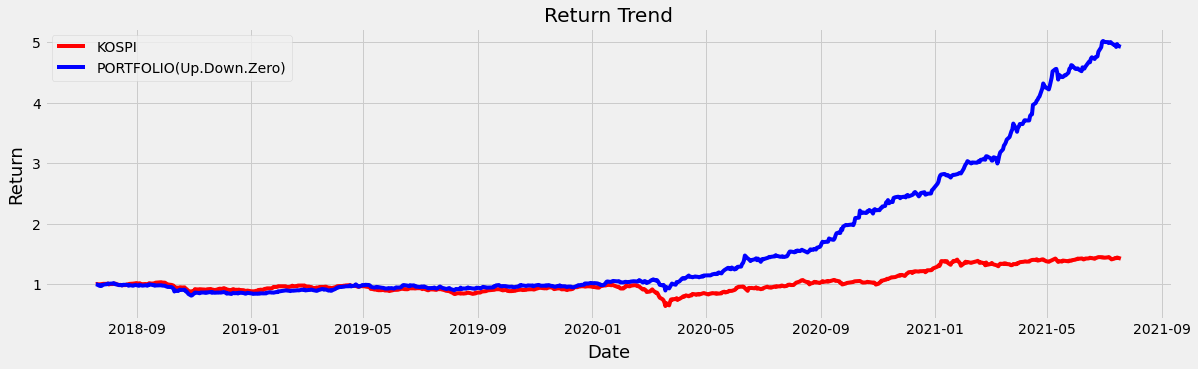

In [ ]:
# 포트폴리오와 KOSPI 지수의 '누적 수익률 추이'를 시각화하여 비교

# matplotlib.pyplot 스타일시트 설정
plt.style.use('fivethirtyeight')

plt.figure(figsize=(18,5))
plt.plot(wealth2.index, wealth2.KOSPI , 'r', label='KOSPI')
plt.plot(wealth2.index, wealth2.PORTFOLIO ,'b', label="PORTFOLIO(Up.Down.Zero)")
plt.grid(True)
plt.title('Return Trend')
plt.xlabel('Date',fontsize=18, labelpad=7)
plt.ylabel('Return',fontsize=18, labelpad=7)
plt.legend(loc='best')
plt.show()

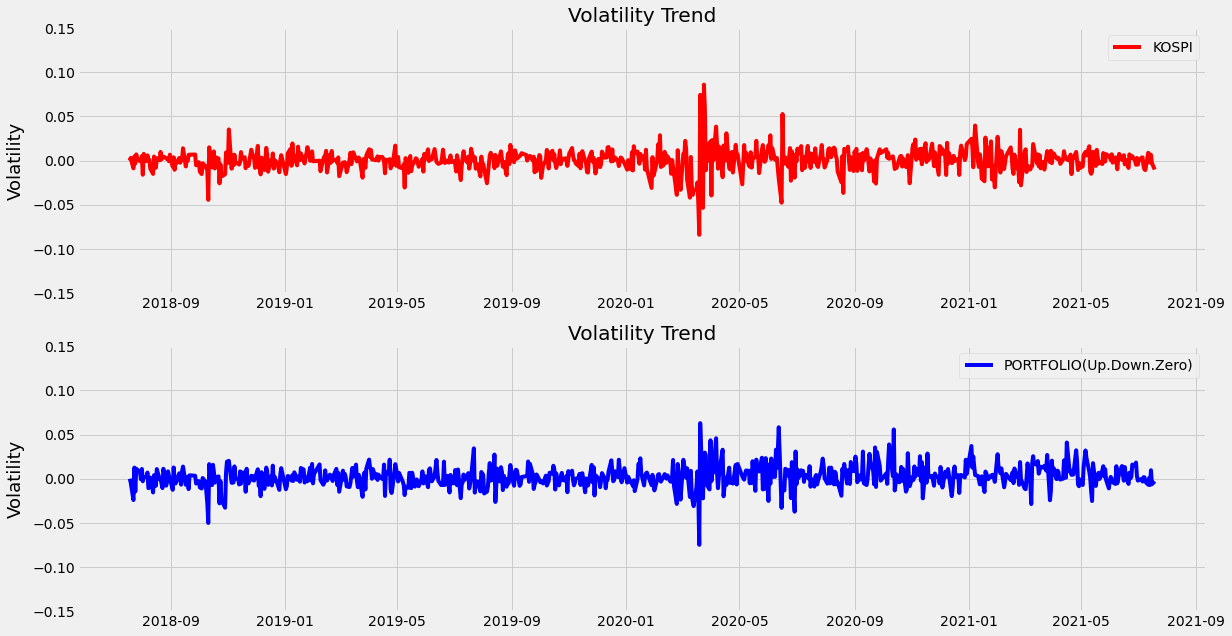

In [ ]:
# 변동률 비교
plt.figure(figsize=(18,10))

plt.subplot(2,1,1)
plt.title('Volatility Trend')

plt.plot(result2.index, result2.KOSPI , 'r', label='KOSPI')
plt.yticks([-0.15, -0.10, -0.05, 0.00, 0.05, 0.10, 0.15])
plt.grid(True)
plt.ylabel('Volatility',fontsize=18, labelpad=7)
plt.legend(loc='best')

plt.subplot(2,1,2)
plt.title('Volatility Trend')
plt.plot(result2.index, result2.PORTFOLIO ,'b', label="PORTFOLIO(Up.Down.Zero)")
plt.yticks([-0.15, -0.10, -0.05, 0.00, 0.05, 0.10, 0.15])
plt.ylabel('Volatility',fontsize=18, labelpad=7)
plt.legend(loc='best')

plt.grid(True)
plt.show()

In [ ]:
portfolio_df_sorted2

,종목명,종목코드,수량(주),투자금액(원),투자비중
0,대성홀딩스,016710,260.0,9620000.0,0.641431
1,HMM,011200,64.0,2809600.0,0.187335
2,삼성공조,006660,41.0,1102900.0,0.073538
3,덕산네오룩스,213420,13.0,772200.0,0.051488
4,피씨엘,241820,10.0,512000.0,0.034139
5,잉크테크,049550,21.0,181020.0,0.012070
합계,NaN,NaN,409.0,14997720.0,1.000000


In [ ]:
print('----- Up.Down.Zero portfolio performance -----')
# Show Funds Remaining
print('Funds Remaining: ', leftover, ' KRW')

# Show Portfolio performance
ef2.portfolio_performance(verbose=True)

----- Up.Down.Zero portfolio performance -----
Funds Remaining:  50.0  KRW
Expected annual return: 77.2%
Annual volatility: 19.9%
Sharpe Ratio: 3.77


(0.7723053715026126, 0.19942129166508799, 3.772442577325439)